### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [5]:
%%time
canary_p = '../../../temp/ref_ccm.p'
pmpm_p = '../../../temp/pmpm_ccm.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pd.read_pickle(canary_p)
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 14.6 s, sys: 17.1 s, total: 31.7 s
Wall time: 31.6 s


pmpm.MEDICAID_LOB.unique()

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [6]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [7]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 33.1 s, sys: 18.9 s, total: 52 s
Wall time: 51.9 s


In [8]:
from utils import ip_er2

In [9]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)

CPU times: user 36.4 s, sys: 6.37 s, total: 42.7 s
Wall time: 42.7 s


In [10]:
%%time
pmpm[['IP_C', 'ER_C']] = pmpm.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
pmpm[['IP_BIN2', 'ER_BIN2']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(pmpm[['IP_C', 'ER_C']]).reset_index(drop = True)

CPU times: user 4min 7s, sys: 18.5 s, total: 4min 25s
Wall time: 4min 18s


#undersample
test = test.sample(random_state = 0, frac = 0.01).reset_index(drop = True)
test = test.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

%%time

test[['IP_C', 'ER_C']] = test.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
test[['IP_BIN2', 'ER_BIN2']] = test.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(test[['IP_C', 'ER_C']]).reset_index(drop = True)

In [11]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  2561295  201510        F               38        190       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   
1  2561295  201511        F               38          3       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   
2  2561295  201512        F               38          0       0.0       0.0        0             0                  0       0          0                    0             0          0              0          0           0       0                 0            0                  0                  0                     0        0                   0              0                        0                  0            0                0          0                      0            0                0            0                  0                 0               0                     0                       0                     0                       0                           0               0               0                 0                0                  0                0               0             0            0               0             0         0               0            0                   0                      0                      0           0                0   

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [12]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 25.4 s, sys: 20 s, total: 45.4 s
Wall time: 45.5 s


In [13]:
canary.principal_reason.value_counts().head(5)

Other: please specify                                             10181
Behavioral Health Other (Specify under Additional Information)     8440
Coordination of Care                                               5296
High Risk Pregnancy                                                4139
Diabetes                                                           2950
Name: principal_reason, dtype: int64

In [14]:
%time
#reduce pmpm dimension and treated dimension
ids = list(pd.DataFrame(controls.PERS_ID.unique()).sample(frac = 0.02)[0])
controls = controls[controls.PERS_ID.isin(ids)].reset_index(drop = True)

#ids2 = list(pd.DataFrame(treated.PERS_ID.unique()).sample(frac = 0.005)[0])
#treated = treated[treated.PERS_ID.isin(ids2)].reset_index(drop = True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


### filter by principal reason

In [15]:
ids2 = canary[canary.principal_reason == "Diabetes"].PERS_ID.unique()
treated = treated[treated.PERS_ID.isin(ids2)].reset_index(drop = True)

In [16]:
controls.PERS_ID.unique().shape, treated.PERS_ID.unique().shape

Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [98]:
%%time
treated2 = in_canary(treated.copy(), canary2)
#treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 15 s, sys: 157 ms, total: 15.2 s
Wall time: 15.2 s


In [99]:
treated2.PERS_ID.unique().shape

In [100]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'IP_BIN2', 'ER_BIN2']

In [185]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2']
hier_cols = None
hier_range = None #[1,1]
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" : 1, 'exact_match': True}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

"""
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" = 1}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)
"""


Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:837 before they were:13090
There were no matches for 179 out of 49926 patients
CPU times: user 5min 9s, sys: 5.6 ms, total: 5min 9s
Wall time: 5min 9s


'\n#columns_to_match = columns_to_match + [\'IP_BIN2\', \'ER_BIN2\']\npropensity_func_args = {\'match_on\':columns_to_match, \'neighbors_per_treated\': 5, \'onset\': "CC_DIABETES", "onset_val" = 1}\nmatched0, matched_data0 = matched_population(treated2.copy(), \n                                           controls.copy(),\n                                           propensity_func, \n                                           propensity_func_args)\n'

####  In addition to the previously created matched groups create a random group

In [186]:
Path('./tempHybridSelection').mkdir(exist_ok = True)
p = './tempHybridSelection/'
matched_data0.to_pickle(p+'match0.p')
treated2.to_pickle(p+'treated0.p')

In [187]:
random_matching_func_args = {'neighbors_per_treated': 5}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [188]:
random_controls.to_pickle(p+'random.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [189]:
from utils import statistics_first_month

In [190]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [191]:
%%time
tr_desc0, Ntr, treated_first_month = statistics_first_month(treated2, columns_to_match, return_array = True)
tr_desc0 = tr_desc0.T



con_desc0, Ncon, controls_first_month = statistics_first_month(matched_data0, columns_to_match, return_array = True)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

pmpm_desc, Npmpm = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc, Nra = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 4min 54s, sys: 8.58 s, total: 5min 3s
Wall time: 5min 3s


In [192]:
import scipy.stats as sts

In [193]:
args = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'], 'mean2':con_desc0['mean'], 'std2':con_desc0['std'], 'nobs1': np.full(len(tr_desc0), Ntr) , 'nobs2': np.full(len(tr_desc0), Ncon)}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [194]:
alli = pd.concat((tr_desc0['mean'], con_desc0['mean'], stats, pmpm_desc['mean'], random_desc['mean']), axis = 1, keys = ['Treated', 'Matched Controls', 'T-Test', 'Genaral Population', 'Random'] )

## Statistics on matching date

In [195]:
alli

Treated Matched Controls    T-Test               Genaral Population      Random
                        mean             mean    t-stat          pval               mean        mean
AGE_AT_MIDMONTH    53.714558        58.732006 -7.646071  3.061952e-14          35.256735   35.007802
ALLOW_AMT        2592.286713      1124.044410  5.057553  4.594049e-07         501.015156  420.070219
MBR_GNDR            0.488875         0.526799 -1.629572  1.033336e-01           0.481626    0.475357
CC_TOBACCO          0.173554         0.094946  4.744274  2.225331e-06           0.041088    0.041484
CC_PRESSURE         0.046408         0.033691  1.351494  1.766747e-01           0.004090    0.003996
CC_OBESITY          0.389701         0.320061  3.105036  1.926532e-03           0.050181    0.053853
CC_HYPERTENSION     0.598220         0.600306 -0.091396  9.271859e-01           0.102356    0.102759
CC_HYPOTHYROID      0.100445         0.096478  0.284858  7.757793e-01           0.025070    0.032731
CC_DX_CNT           4.882390         4.445636  3.301257  9.777474e-04           0.920962    0.943102
IP_BIN2             0.174189         0.056662  6.317498  3.200908e-10           0.017570    0.020742
ER_BIN2             0.255563         0.059724  7.830292  7.471045e-15           0.021684    0.084872

In [196]:
tr_desc0A = treated2[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0A = tr_desc0A.T


con_desc0A = matched_data0[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0A = con_desc0A.T


pmpm_descA = pmpm2[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_descA = pmpm_descA.T

random_descA = random_controls[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_descA = random_descA.T



#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [197]:
args = {'mean1':tr_desc0A['mean'], 'std1':tr_desc0A['std'],
        'mean2':con_desc0A['mean'], 'std2':con_desc0A['std'],
        'nobs1': np.full(len(tr_desc0), len(treated2)) , 'nobs2': np.full(len(tr_desc0), len(matched_data0))}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [198]:
alli2 = pd.concat((tr_desc0A, con_desc0A, stats['pval'], pmpm_descA['mean'], random_descA['mean']), axis = 1, keys = ['Treated',
                                                                                 'Matched Controls','T-Test',
                                                                                'Genaral Population', 
                                                                                 'Random'] )
alli2

Treated              Matched Controls                      T-Test Genaral Population      Random
                        mean          std             mean          std           pval               mean        mean
AGE_AT_MIDMONTH    56.332532    13.425710        60.669713    13.475486   0.000000e+00          38.128488   37.267494
ALLOW_AMT        1558.852301  7860.085366      1188.565237  4338.105575   3.344789e-11         486.846157  342.491795
MBR_GNDR            0.476004     0.499429         0.503882     0.499996   3.593180e-12           0.471587    0.473211
CC_TOBACCO          0.176481     0.381233         0.100972     0.301298  2.570557e-151           0.060322    0.044828
CC_PRESSURE         0.048652     0.215142         0.036644     0.187891   4.983198e-13           0.006250    0.003901
CC_OBESITY          0.457617     0.498205         0.383834     0.486329   5.598235e-77           0.107772    0.092828
CC_HYPERTENSION     0.613568     0.486936         0.624063     0.484375   7.141946e-03           0.155155    0.124382
CC_HYPOTHYROID      0.120899     0.326013         0.107360     0.309577   1.474575e-07           0.040193    0.039244
CC_DX_CNT           5.571386     3.310816         4.987135     2.819474  1.350768e-116           1.518776    1.223646
IP_BIN2             0.121920     0.419907         0.063262     0.305509   5.294028e-79           0.033013    0.017776
ER_BIN2             0.226035     0.632934         0.100084     0.352089  2.020212e-171           0.104381    0.088426

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [199]:
#mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco use', 'Pressure', 'Obesity', 
                                     #'Hypertension', 'Hypothyroid', 'Disease Count', 'Inpatient Visits', 'Emergency Vistits', 'Line of Bussiness']))
mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [200]:
p = Path('./res/figs')
p.mkdir(parents = True, exist_ok = True)

In [201]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

1. treated_first_month
2. controls_first_month

In [202]:
from diabetes_onset_plotter import plot_hist


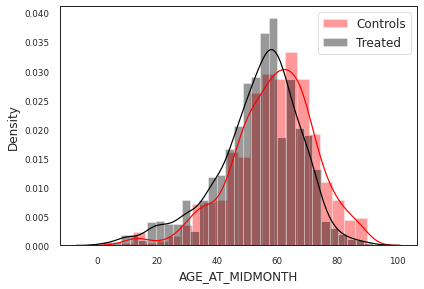

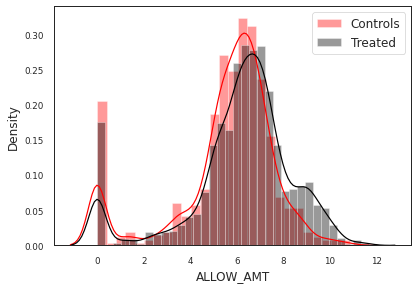

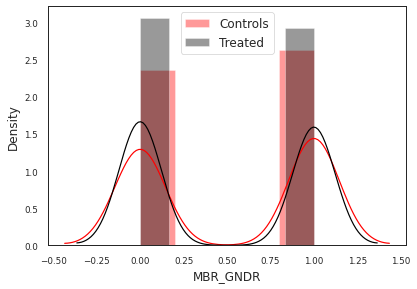

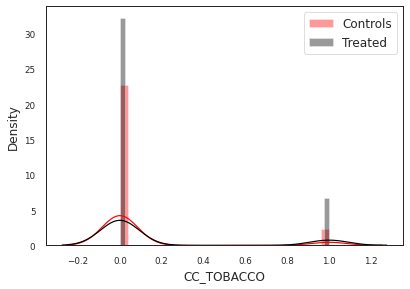

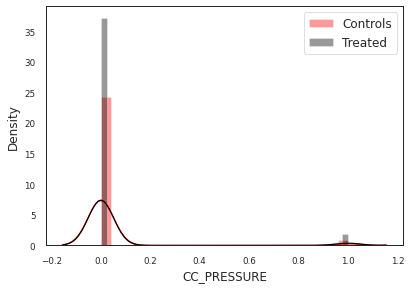

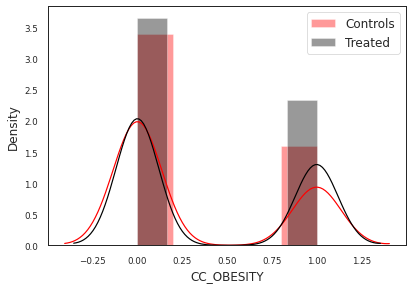

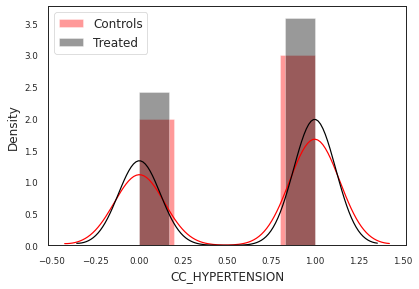

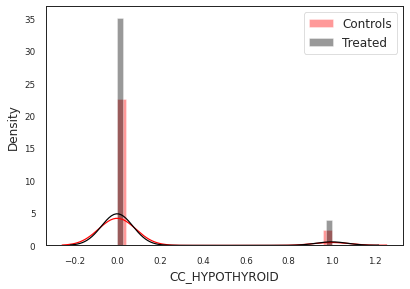

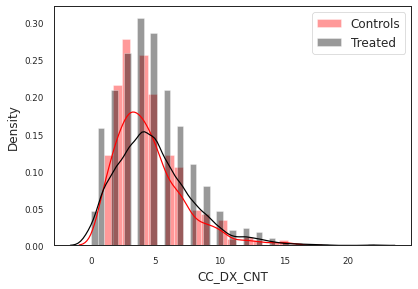

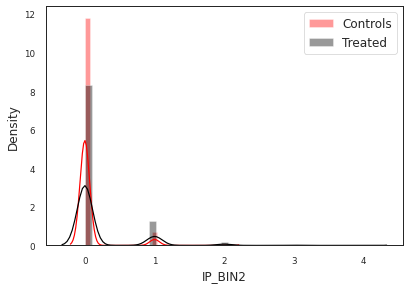

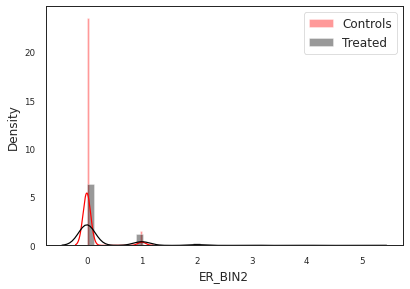

In [203]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = 'res/figs/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

In [204]:
from diabetes_onset_plotter import save_arrays
p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

In [205]:
all_paper


Treated  Matched Controls  T-Statistic  p-value  General Population  Random Match  Difference
AGE_AT_MIDMONTH    53.715            58.732       -7.646    0.000              35.257        35.008      -5.017
ALLOW_AMT        2592.287          1124.044        5.058    0.000             501.015       420.070    1468.243
MBR_GNDR            0.489             0.527       -1.630    0.103               0.482         0.475      -0.038
CC_TOBACCO          0.174             0.095        4.744    0.000               0.041         0.041       0.079
CC_PRESSURE         0.046             0.034        1.351    0.177               0.004         0.004       0.012
CC_OBESITY          0.390             0.320        3.105    0.002               0.050         0.054       0.070
CC_HYPERTENSION     0.598             0.600       -0.091    0.927               0.102         0.103      -0.002
CC_HYPOTHYROID      0.100             0.096        0.285    0.776               0.025         0.033       0.004
CC_DX_CNT           4.882             4.446        3.301    0.001               0.921         0.943       0.436
IP_BIN2             0.174             0.057        6.317    0.000               0.018         0.021       0.117
ER_BIN2             0.256             0.060        7.830    0.000               0.022         0.085       0.196

In [206]:
only_means

Treated  Matched Controls  General Population  Random Match
AGE_AT_MIDMONTH    53.715            58.732              35.257        35.008
ALLOW_AMT        2592.287          1124.044             501.015       420.070
MBR_GNDR            0.489             0.527               0.482         0.475
CC_TOBACCO          0.174             0.095               0.041         0.041
CC_PRESSURE         0.046             0.034               0.004         0.004
CC_OBESITY          0.390             0.320               0.050         0.054
CC_HYPERTENSION     0.598             0.600               0.102         0.103
CC_HYPOTHYROID      0.100             0.096               0.025         0.033
CC_DX_CNT           4.882             4.446               0.921         0.943
IP_BIN2             0.174             0.057               0.018         0.021
ER_BIN2             0.256             0.060               0.022         0.085

In [207]:
only_stats

Difference  T-Statistic  p-value
AGE_AT_MIDMONTH      -5.017       -7.646    0.000
ALLOW_AMT          1468.243        5.058    0.000
MBR_GNDR             -0.038       -1.630    0.103
CC_TOBACCO            0.079        4.744    0.000
CC_PRESSURE           0.012        1.351    0.177
CC_OBESITY            0.070        3.105    0.002
CC_HYPERTENSION      -0.002       -0.091    0.927
CC_HYPOTHYROID        0.004        0.285    0.776
CC_DX_CNT             0.436        3.301    0.001
IP_BIN2               0.117        6.317    0.000
ER_BIN2               0.196        7.830    0.000